In [1]:
#import relevant packages for analysis

from __future__ import print_function

import os
import sys


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2019-07-23 13:27:36 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2


In [3]:
#Create the path to the data and read into a pandas dataframe

terry_data = os.path.join(PROJ_ROOT, 
                         'data', 'processed',
                         'Terry_Stops_Clean.csv')

data = pd.read_csv(terry_data, parse_dates = ['date'], 
                   index_col = 'date', dtype = {'officer_race':'category','officer_gender':'category',
                                                'subject_age':'category',
                                                'subject_race':'category','subject_gender': 'category',
                                                'stop_resolution': 'category','weapon_type':'category',
                                                'call_type':'category','arrest':'int32', 'frisk':'float',
                                                'precinct':'category', 'sector':'category', 'beat': 'category'})

data.sort_index(inplace = True)

data['count'] = 1

In [4]:
len(data.index)

34050

In [5]:
# verify that the number of subjects for each race that may be analyzed can be considered a normal distribution
for race in data.subject_race.unique():
    no_obs = len(data[data.subject_race == race])
    assert no_obs > 30, race + ' not greater than 30'

# verify that the number of officers for each race that may be analyzed can be considered a normal distribution    
for race in data.officer_race.unique():
    no_obs = len(data[data.officer_race == race])
    assert no_obs > 30, race + ' not greater than 30'

#Checking that the observations are less than 10% of the population
pop = 730400

#Create dataframe with census population percentages
df = pd.DataFrame(index = ['American Indian / Alaskan Native','Asian','Black','Hispanic',
                           'Multi-Racial','Other','White'], 
                  data = {'census_pct' : [.04,.137,.077,.066,.044,.002,.663,]} )



In order for the Central Limit Theorem to apply, the sample(s) must be sufficiently large (n>30)

The sample sizes are less than 10% of the population



In [6]:
# Bootstrap replicate function for repeatability
def bootstrap_replicate_1d(data, func):
    """Create a bootstrap replicates."""
    
    boot_sample = np.random.choice(data, size=len(data))  # create bootstrap sample
    return func(boot_sample) # apply function to bootstrap

# Apply bootstrap replicate function 'n' and return an array
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    boot_rep = np.empty(size) # initialize array of replicates: bs_replicates
    for i in range(size):  # generate 'n' number of replicates
        boot_rep[i] = bootstrap_replicate_1d(data, func)
    return boot_rep

def diff_from_census(data, census_value = .077):
    return np.mean(data) - census_value

#### Statistical Testing

Is there a meaningful difference between the proportion of black subjects stopped and the proportion of black residents according to the census data?

$H$o: The census black population percentage is the same as the percentage of black subjects that were stopped. 

$H$a: The census black population percentage is ***not*** the same as the percentage of black subjects that were stopped

Significance Level: *95%* Confidence. <br> $α$ = 0.05

In [7]:
black_prop = len(data[data.subject_race == 'Black']) / len(data)
black_prop

0.3079588839941263

In [8]:
#difference between the census data and the proportion of blacks stopped in the data
diff_obs = diff_from_census(black_prop)
diff_obs

0.23095888399412628

In [9]:

#simulate the data an array of data where the proportion of stops is equal to the census data
race_data_shifted = np.random.binomial(1, .077, size = len(data) )

#create bootstrap replicates with the test statistic being the difference of the proportion of stops & the census data
bs_reps = draw_bs_reps(race_data_shifted, diff_from_census, 10000)
np.mean(bs_reps)

0.0016083230543318657

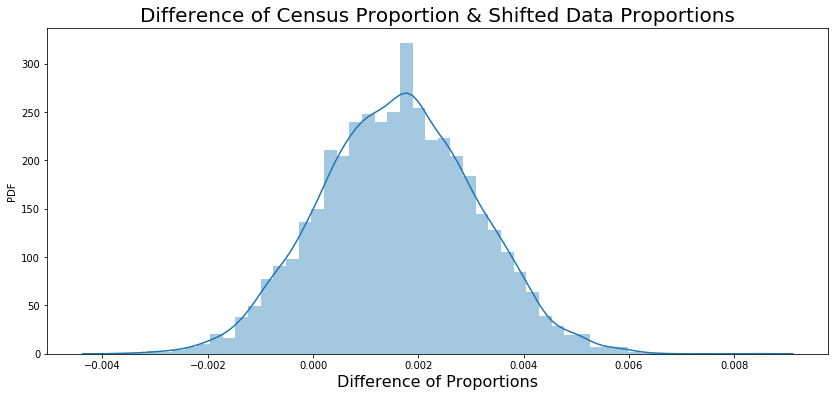

In [10]:
#plot the differences
_=plt.figure(figsize=(14, 6))
sns.distplot(bs_reps, kde = True)
_=plt.title('Difference of Census Proportion & Shifted Data Proportions', fontsize = 20)
_=plt.xlabel('Difference of Proportions', fontsize = 16)
_=plt.ylabel('PDF')

In [11]:
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print('There is a 95% CI that the difference between the census data & observed data would be between'
      '{:.4f} and {:.4f}, \n the observed difference was {:.4f}'.format(conf_int[0], conf_int[1], diff_obs)) 

There is a 95% CI that the difference between the census data & observed data would be between-0.0012 and 0.0044, 
 the observed difference was 0.2310


In [12]:
p_value = np.sum(bs_reps >= diff_obs) / 1000
p_value

0.0

We can reject the null hypothesis that the census population of black residents and the black proportion of Terry Stops is the same

#### Statistical Testing

Is there a meaningful difference in the proportion of Native Alaskans greater than 36 years old stopped than Non-Native Alaskans?

$H$o: The proportions of Native Alaskans 36 years or older is the same as Non-Native Alaskans

$H$a: The proportions of Native Alaskans 36 years or older is ***not*** the same as Non-Native Alaskans

Significance Level: *95%* Confidence. <br> $α$ = 0.05

In [13]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Combine the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def diff_of_prop(data_1, data_2):
    """ Difference in the proportions of two binomial arrays"""
    
    #The difference of proportions of data_1 and data_2
    diff = np.mean(data_1) - np.mean(data_2)
    
    return diff
    

In [14]:

age_range = ['36 - 45', '46 - 55', '56 and Above']

#subset the data of only Native Americans
na_over_36 = data[data.subject_race == 'American Indian / Alaskan Native'] 
#create an array if the subject is over 36
na_over_36 = na_over_36.subject_age.isin(age_range)
na_over_36 = na_over_36.values * 1 

#subset the data of Non - Native Americans
other_over_36 = data[data.subject_race != 'American Indian / Alaskan Native']
#create an array if the subject is over 36
other_over_36 = other_over_36.subject_age.isin(age_range)
other_over_36 = other_over_36.values * 1

#The difference between the two proportions
obs_diff = np.mean(na_over_36) - np.mean(other_over_36)



In [15]:
#create 1,000 permutation replicates of native americans and non native americans over 36
#And calculate the difference in proportions
perm_reps = draw_perm_reps(na_over_36, other_over_36, diff_of_prop, size = 10000)

In [16]:
#Find a p value, those replicates that were greater or equal to the observed difference in the data
p = np.sum(perm_reps >= obs_diff) / len(perm_reps)
p

0.0

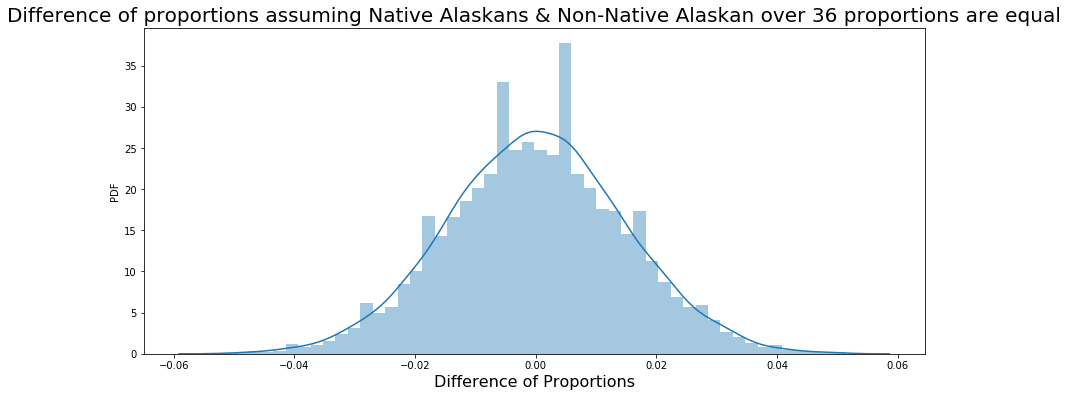

In [17]:
#plot the differences
_=plt.figure(figsize=(14, 6))
sns.distplot(perm_reps, kde = True)
_=plt.title('Difference of proportions assuming Native Alaskans & Non-Native Alaskan over 36 proportions are equal', fontsize = 20)
_=plt.xlabel('Difference of Proportions', fontsize = 16)
_=plt.ylabel('PDF')

In [18]:
conf_int = np.percentile(perm_reps, [2.5, 97.5])
print('There is a 95% CI that the difference between the Alaskan Natives & Non-Alaskan Natives over 36 would be between'
      '{:.4f} and {:.4f}, \n the observed difference was {:.4f}'.format(conf_int[0], conf_int[1], obs_diff))

There is a 95% CI that the difference between the Alaskan Natives & Non-Alaskan Natives over 36 would be between-0.0291 and 0.0295, 
 the observed difference was 0.1164


We can reject the null hypothesis that the proportions of Native Alaskans 36 years or older is the same as Non-Native Alaskans

#### Statistical Testing

Is there a meaningful difference in the proportion of Black subjects less than 17 years old stopped than Non-Black Subjects?

$H$o: The proportions of Black subjects less than 17 years is the same as Non-Black subjects of the same age group

$H$a: The proportions of Black subjects less than 17 years is ***not*** the same as Non-Black subjects of the same age group

Significance Level: *95%* Confidence. <br> $α$ = 0.05

In [19]:
#subset the data for only Black subjects
b_less_17 = data[data.subject_race == 'Black']
#create an array for those that are in the 1-17 age category
b_less_17 = b_less_17.subject_age == '1 - 17'
b_less_17 = b_less_17.values * 1

#subset the data for only non-Black subjects
other_less_17 = data[data.subject_race != 'Black']
#create an array for those that are in the 1-17 age category
other_less_17 = other_less_17.subject_age == '1 - 17'
other_less_17 = other_less_17.values * 1

#The difference between the two proportions
obs_diff = np.mean(b_less_17) - np.mean(other_less_17)
obs_diff

0.045573079097663116

In [20]:
#Create 1,000 permutation replicates for black & non-black subjects less than 17 years of age
#and calculate the test statistic of the differences of the proportions
perm_reps = draw_perm_reps(b_less_17, other_less_17, diff_of_prop, size = 10000)

In [21]:
#find the number of replicates where the difference is at least as great as the observed difference or greater
p = np.sum(perm_reps >= obs_diff) / len(perm_reps)
p

0.0

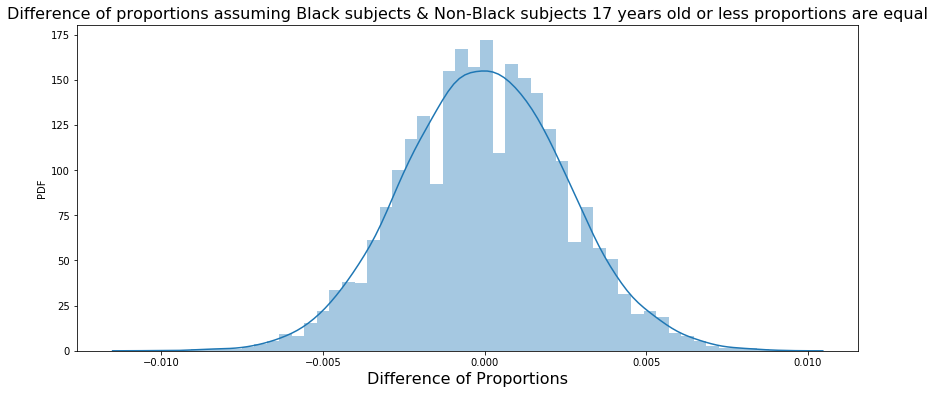

In [22]:
#plot the differences
_=plt.figure(figsize=(14, 6))
sns.distplot(perm_reps, kde = True)
_=plt.title('Difference of proportions assuming Black subjects & Non-Black subjects 17 years old or less proportions are equal', fontsize = 16)
_=plt.xlabel('Difference of Proportions', fontsize = 16)
_=plt.ylabel('PDF')

In [23]:
conf_int = np.percentile(perm_reps, [2.5, 97.5])
print('There is a 95% CI that the difference in proportions between Black subjects & Non-Black subjects <17 years old '
      'be between \n {:.4f} and {:.4f}, the observed difference was {:.4f}'.format(conf_int[0], conf_int[1], obs_diff))

There is a 95% CI that the difference in proportions between Black subjects & Non-Black subjects <17 years old be between 
 -0.0049 and 0.0051, the observed difference was 0.0456


We can reject the null hypothesis that the proportions of Black subjects less than 17 years old is the same as Non-Black Subjects

#### Statistical Testing

Is there a meaningful difference in the proportion of White subjects that are stopped and arrested or frisked than Non-White subjects?

$H$o: The proportion of White subjects that are frisked and/or arrested is the same as Non-White subjects

$H$a: The proportion of White subjects that are frisked and/or arrested is ***not*** same as Non-White subjects

Significance Level: *95%* Confidence. <br> $α$ = 0.05

In [24]:
#subset the data for white and non-white subjects
#from that subset identify those that are frisked or arrested
#find the observed differences between both groups of subjects from both groups

w_frisked = data[data.subject_race == 'White']
w_frisked = w_frisked.frisk == 1
w_frisked = w_frisked.values * 1

w_arrested = data[data.subject_race == 'White']
w_arrested = w_arrested.arrest == 1
w_arrested = w_arrested.values * 1


nw_frisked = data[data.subject_race != 'White']
nw_frisked = nw_frisked.frisk == 1
nw_frisked = nw_frisked.values * 1


nw_arrested = data[data.subject_race != 'White']
nw_arrested = nw_arrested.arrest == 1
nw_arrested = nw_arrested.values * 1

obs_diff_frisked = np.mean(w_frisked) - np.mean(nw_frisked)
obs_diff_arrested = np.mean(w_arrested) - np.mean(nw_arrested)

In [25]:
#observed differences
print(obs_diff_frisked, obs_diff_arrested)

-0.07268648327603514 -0.03129576960680311


In [26]:
#Create 1,000 permutation replicates for white & non-white subjects
#and calculate the test statistic of the differences of the proportions for incidents of arrested & frisked

perm_reps_frisked = draw_perm_reps(w_frisked, nw_frisked, diff_of_prop, size = 10000)
perm_reps_arrested = draw_perm_reps(w_arrested, nw_arrested, diff_of_prop, size = 10000)

In [27]:
#find the number of replicates where the difference is at most as great as the observed difference or smaller
p_frisked = np.sum(perm_reps_frisked <= obs_diff_frisked) / len(perm_reps_frisked)
p_frisked

0.0

In [28]:
#find the number of replicates where the difference is at most as great as the observed difference or smaller
p_arrested = np.sum(perm_reps_arrested <= obs_diff_arrested) / len(perm_reps_arrested)
p_arrested

0.0

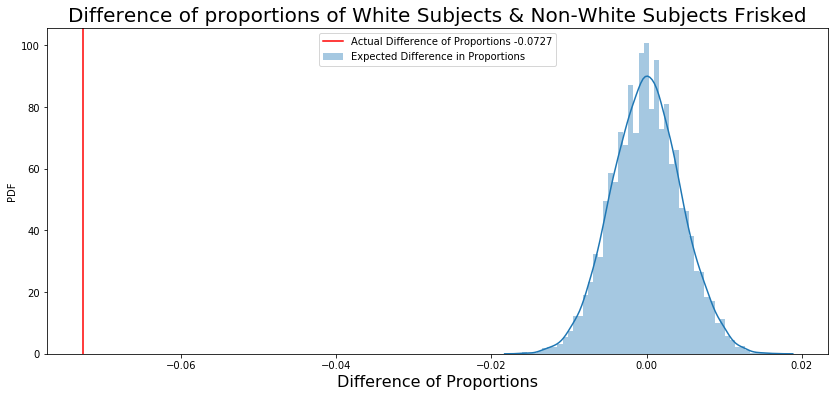

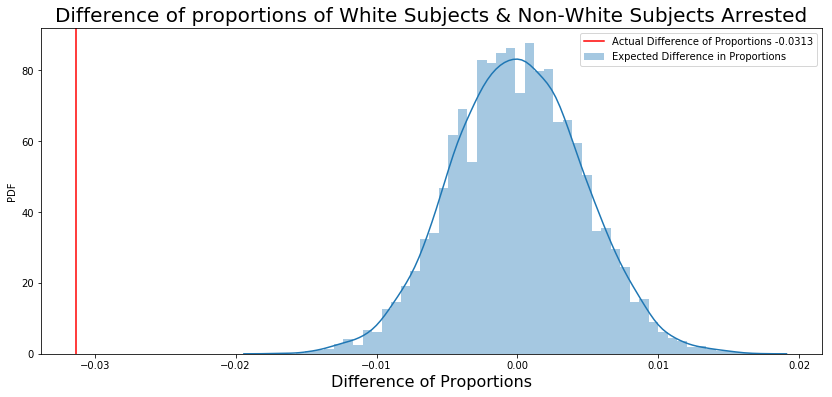

In [33]:


#plot the differences
_=plt.figure(figsize=(14, 6)) #adjust the figure size
sns.distplot(perm_reps_frisked, kde = True)
_=plt.axvline(x=obs_diff_frisked, color = 'r')  #create a line to display where the observed difference is located
_=plt.title('Difference of proportions of White Subjects & Non-White Subjects Frisked', fontsize = 20)
_=plt.xlabel('Difference of Proportions', fontsize = 16)
_=plt.ylabel('PDF')
_=plt.legend(['Actual Difference of Proportions {:.4f}'.format(obs_diff_frisked),'Expected Difference in Proportions'],
            loc = 'best')
_=plt.show()



#plot the differences
_=plt.figure(figsize=(14, 6))   #adjust the figure size
sns.distplot(perm_reps_arrested, kde = True)
_=plt.axvline(x=obs_diff_arrested, color = 'r')  #create a line to display where the observed difference is located
_=plt.title('Difference of proportions of White Subjects & Non-White Subjects Arrested', fontsize = 20)
_=plt.xlabel('Difference of Proportions', fontsize = 16)
_=plt.ylabel('PDF')
_=plt.legend(['Actual Difference of Proportions {:.4f}'.format(obs_diff_arrested),'Expected Difference in Proportions'],
            loc = 'best')
_=plt.show()

In [30]:
conf_int = np.percentile(perm_reps_frisked, [2.5, 97.5])
print('There is a 95% CI that the difference in proportions between White Subjects & Non-White subjects stopped and frisked'
      ' is between \n {:.4f} and {:.4f}, the observed difference was {:.4f}'.format(conf_int[0], conf_int[1], obs_diff_frisked))

There is a 95% CI that the difference in proportions between White Subjects & Non-White subjects stopped and frisked is between 
 -0.0088 and 0.0089, the observed difference was -0.0727


In [32]:
conf_int = np.percentile(perm_reps_arrested , [2.5, 97.5])
print('There is a 95% CI that the difference in proportions between White Subjects & Non-White subjects stopped and frisked'
      ' is between \n {:.4f} and {:.4f}, the observed difference was {:.4f}'.format(conf_int[0], conf_int[1], obs_diff_arrested))

There is a 95% CI that the difference in proportions between White Subjects & Non-White subjects stopped and frisked is between 
 -0.0091 and 0.0090, the observed difference was -0.0313


We can reject the null hypothesis that the proportions of White and Non-White Subjects are frisked and arrested the at the same proportions of Non-White Subjects.

From the data it is found that proportion of Black Subjects are stopped at a significantly higher level than the black proportion of Black Seattle residents. That the Native Alaskans 36 and older are stopped at higher rates than Non-Native Alaskans 36 and older. Black subjects 17 and younger are stopped at higher rates than Non-Black subjects in the same age group. And that White subjects that are stopped are less likely than Non-White subjects to be arrested or frisked. 

To gain a better understanding it would be worth analysing the neighborhoods in which these stops were completed and for what offenses. 